步骤1：基础设置和初始化

In [1]:
import os                    # 用于文件系统操作
import json                  # 用于读取JSON文件
import torch                 # PyTorch库，用于加载.pt文件
import numpy as np           # 数值计算库
import matplotlib.pyplot as plt  # 绘图库
from pathlib import Path     # 现代化的路径操作
from collections import defaultdict  # 默认字典，方便数据统计

# 设置matplotlib的显示参数
plt.rcParams['font.size'] = 10           # 设置字体大小
plt.rcParams['figure.dpi'] = 100         # 设置图片分辨率
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

步骤2：数据加载函数

In [2]:
class AudioDataLoader:
    """音频数据加载和管理类"""
    
    def __init__(self, data_dir):

        self.data_dir = Path(data_dir)              # 将字符串路径转换为Path对象
        self.metadata = None                        # 存储metadata.json的内容
        self.all_file_paths = []                   # 存储所有音频文件的路径列表
        self.speaker_to_files = {}                 # 存储每个说话人对应的文件列表
        
        # 执行初始化步骤
        self._load_metadata()                      # 加载metadata.json文件
        self._collect_all_files()                  # 收集所有音频文件路径
        
    def _load_metadata(self):
        """加载metadata.json文件（私有方法）"""
        metadata_path = self.data_dir / "metadata.json"  # 构建metadata文件的完整路径
        
        # 检查文件是否存在
        if not metadata_path.exists():
            print(f"❌ 警告: {metadata_path} 文件不存在")
            return
        
        # 读取并解析JSON文件
        try:
            with open(metadata_path, 'r', encoding='utf-8') as f:  # 打开文件，指定UTF-8编码
                self.metadata = json.load(f)              # 解析JSON内容
            print(f"✅ 成功加载metadata，包含 {len(self.metadata['speakers'])} 个说话人")
        except Exception as e:
            print(f"❌ 加载metadata失败: {e}")
            
    def _collect_all_files(self):
        """收集所有音频文件的路径信息（私有方法）"""
        if self.metadata is None:                         # 如果metadata加载失败，直接返回
            return
            
        file_count = 0                                    # 计数器：记录总文件数
        
        # 遍历metadata中的每个说话人
        for speaker_id, utterances in self.metadata['speakers'].items():
            self.speaker_to_files[speaker_id] = []        # 初始化该说话人的文件列表
            
            # 遍历该说话人的每个语音文件
            for utterance in utterances:
                feature_path = utterance['feature_path']   # 获取特征文件的相对路径
                self.all_file_paths.append(feature_path)  # 添加到总文件列表
                self.speaker_to_files[speaker_id].append(feature_path)  # 添加到该说话人的文件列表
                file_count += 1                           # 增加文件计数
        
        print(f"✅ 收集完成，总共找到 {file_count} 个音频文件")
        print(f"📊 平均每个说话人有 {file_count/len(self.speaker_to_files):.1f} 个文件")

# 创建数据加载器实例
data_loader = AudioDataLoader("Dataset")  # 请根据你的实际路径修改这里

✅ 成功加载metadata，包含 600 个说话人
✅ 收集完成，总共找到 56666 个音频文件
📊 平均每个说话人有 94.4 个文件


步骤3：单个文件加载函数

In [3]:
def load_single_audio_file(data_loader, file_path):
    # 构建完整的文件路径
    full_path = data_loader.data_dir / file_path
    
    # 检查文件是否存在
    if not full_path.exists():
        print(f"❌ 文件不存在: {file_path}")
        return None, None
    
    try:
        # 使用torch.load()加载.pt文件
        mel_features = torch.load(full_path, map_location='cpu')  # map_location='cpu'确保在CPU上加载
        
        # 如果是torch.Tensor，转换为numpy数组以便处理
        if isinstance(mel_features, torch.Tensor):
            mel_features = mel_features.numpy()
        
        # 收集文件信息
        file_info = {
            'path': file_path,                           # 文件路径
            'shape': mel_features.shape,                 # 数据形状 (时间帧数, 频率维度)
            'duration_frames': mel_features.shape[0],    # 时间帧数
            'frequency_bins': mel_features.shape[1],     # 频率维度（通常是40）
            'min_value': mel_features.min(),             # 最小值
            'max_value': mel_features.max(),             # 最大值
            'mean_value': mel_features.mean(),           # 平均值
        }
        
        return mel_features, file_info
        
    except Exception as e:
        print(f"❌ 加载文件失败 {file_path}: {e}")
        return None, None

# 测试加载第一个文件
if len(data_loader.all_file_paths) > 0:
    first_file = data_loader.all_file_paths[0]           # 获取第一个文件路径
    mel_data, file_info = load_single_audio_file(data_loader, first_file)
    
    if mel_data is not None:
        print(f"✅ 成功加载第一个文件: {first_file}")
        print(f"📊 文件信息: {file_info}")
    else:
        print("❌ 第一个文件加载失败")
else:
    print("❌ 没有找到任何音频文件")

✅ 成功加载第一个文件: uttr-18e375195dc146fd8d14b8a322c29b90.pt
📊 文件信息: {'path': 'uttr-18e375195dc146fd8d14b8a322c29b90.pt', 'shape': (435, 40), 'duration_frames': 435, 'frequency_bins': 40, 'min_value': -20.723267, 'max_value': 6.2613044, 'mean_value': -2.3047051}


C:\Users\yukot\AppData\Local\Temp\ipykernel_27504\1361899104.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mel_features = torch.load(full_path, map_location='cpu')  #

步骤4：获取前8个文件函数

In [4]:
def get_first_n_files(data_loader, n=8):
    results = []                                         # 存储结果的列表
    successful_loads = 0                                 # 成功加载的文件计数
    attempted_files = 0                                  # 尝试加载的文件计数
    
    print(f"🔄 开始加载前 {n} 个音频文件...")
    
    # 遍历文件列表，直到成功加载n个文件或遍历完所有文件
    for file_path in data_loader.all_file_paths:
        attempted_files += 1                             # 增加尝试计数
        
        # 尝试加载当前文件
        mel_features, file_info = load_single_audio_file(data_loader, file_path)
        
        if mel_features is not None:                     # 如果加载成功
            results.append((mel_features, file_info))   # 添加到结果列表
            successful_loads += 1                       # 增加成功计数
            print(f"✅ [{successful_loads}/{n}] 加载成功: {file_path[:50]}...")  # 显示进度
            
            if successful_loads >= n:                    # 如果已经加载够了n个文件
                break                                    # 跳出循环
        else:
            print(f"⚠️  [{attempted_files}] 跳过文件: {file_path}")
    
    print(f"📋 加载完成: 成功 {successful_loads} 个，尝试 {attempted_files} 个")
    return results

# 获取前8个文件
first_8_files = get_first_n_files(data_loader, n=8)
print(f"\n🎯 最终获得 {len(first_8_files)} 个有效文件")

🔄 开始加载前 8 个音频文件...
✅ [1/8] 加载成功: uttr-18e375195dc146fd8d14b8a322c29b90.pt...
✅ [2/8] 加载成功: uttr-da9917d5853049178487c065c9e8b718.pt...
✅ [3/8] 加载成功: uttr-fe3576f81b5841ab8931c1dd611bf547.pt...
✅ [4/8] 加载成功: uttr-c4174a7e92eb44128d2689b75bf8557a.pt...
✅ [5/8] 加载成功: uttr-33067092c5ff4b9daff8483eacf1dc3f.pt...
✅ [6/8] 加载成功: uttr-53121c34421d4891a3010ec588d524f7.pt...
✅ [7/8] 加载成功: uttr-e8fa20874fd64b718fd98895afa45a41.pt...
✅ [8/8] 加载成功: uttr-024df10464294b5ea47b1e875797f89f.pt...
📋 加载完成: 成功 8 个，尝试 8 个

🎯 最终获得 8 个有效文件


C:\Users\yukot\AppData\Local\Temp\ipykernel_27504\1361899104.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mel_features = torch.load(full_path, map_location='cpu')  #

步骤5：可视化前8个文件（一行4个，共2行）

🎨 开始可视化前8个mel-spectrogram...


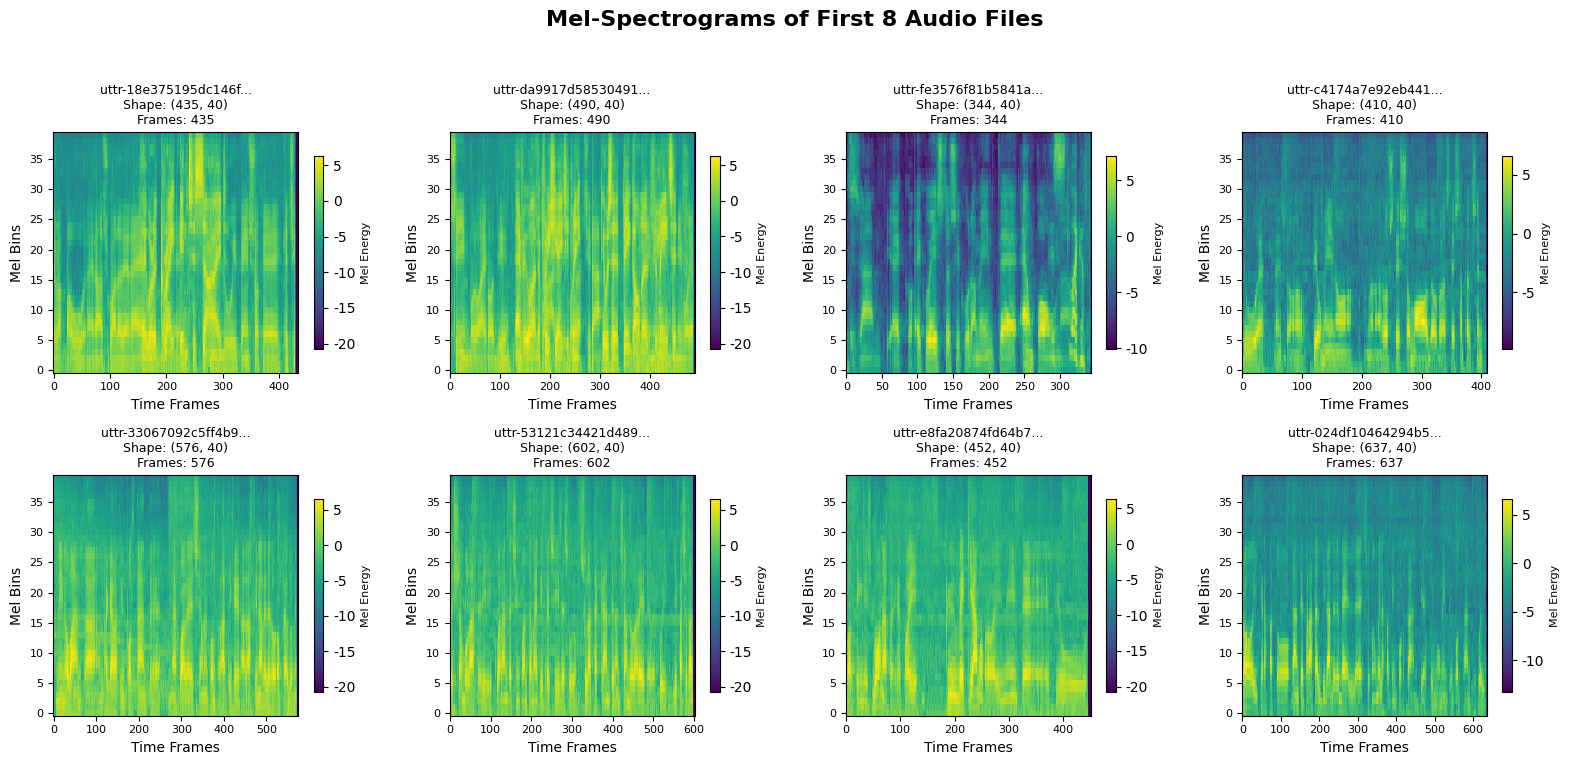


📊 详细信息:
[1] uttr-18e375195dc146fd8d14b8a322c29b90.pt
    形状: (435, 40), 时长: 435帧, 范围: [-20.723, 6.261]
[2] uttr-da9917d5853049178487c065c9e8b718.pt
    形状: (490, 40), 时长: 490帧, 范围: [-20.723, 6.213]
[3] uttr-fe3576f81b5841ab8931c1dd611bf547.pt
    形状: (344, 40), 时长: 344帧, 范围: [-10.052, 7.123]
[4] uttr-c4174a7e92eb44128d2689b75bf8557a.pt
    形状: (410, 40), 时长: 410帧, 范围: [-9.801, 6.569]
[5] uttr-33067092c5ff4b9daff8483eacf1dc3f.pt
    形状: (576, 40), 时长: 576帧, 范围: [-20.723, 6.487]
[6] uttr-53121c34421d4891a3010ec588d524f7.pt
    形状: (602, 40), 时长: 602帧, 范围: [-20.723, 6.492]
[7] uttr-e8fa20874fd64b718fd98895afa45a41.pt
    形状: (452, 40), 时长: 452帧, 范围: [-20.723, 6.270]
[8] uttr-024df10464294b5ea47b1e875797f89f.pt
    形状: (637, 40), 时长: 637帧, 范围: [-13.257, 6.602]


In [5]:
def visualize_first_8_mels(audio_data_list, figsize=(16, 8)):
    """
    可视化前8个mel-spectrogram，采用2行4列的布局
    
    Args:
        audio_data_list (list): 包含(mel_features, file_info)的列表
        figsize (tuple): 整体图片的大小，默认(16, 8)
    """
    # 确定实际要显示的文件数量（最多8个）
    n_files = min(len(audio_data_list), 8)
    
    if n_files == 0:
        print("❌ 没有可显示的文件")
        return
    
    # 创建2行4列的子图布局
    fig, axes = plt.subplots(2, 4, figsize=figsize)    # 2行4列，总共8个子图
    fig.suptitle('Mel-Spectrograms of First 8 Audio Files', fontsize=16, fontweight='bold')  # 设置总标题
    
    # 将axes转换为一维数组，方便索引
    axes_flat = axes.flatten()                          # 将2x4的axes数组展平为1x8
    
    # 遍历每个文件进行可视化
    for i in range(8):                                  # 遍历8个位置
        ax = axes_flat[i]                              # 获取当前子图
        
        if i < n_files:                                # 如果有对应的文件
            mel_features, file_info = audio_data_list[i]  # 获取mel特征和文件信息
            
            # 绘制mel-spectrogram
            # 转置：将(时间, 频率)转为(频率, 时间)，因为imshow的y轴是从上到下的
            img = ax.imshow(mel_features.T,             # 转置数据
                           aspect='auto',               # 自动调整宽高比
                           origin='lower',              # y轴从下到上（低频到高频）
                           cmap='viridis',              # 使用viridis颜色映射
                           interpolation='nearest')     # 最近邻插值
            
            # 设置坐标轴标签
            ax.set_xlabel('Time Frames', fontsize=10)   # x轴：时间帧
            ax.set_ylabel('Mel Bins', fontsize=10)      # y轴：梅尔频率仓
            
            # 设置子图标题，包含文件信息
            file_name = file_info['path'].split('/')[-1]  # 提取文件名（去掉路径）
            ax.set_title(f'{file_name[:20]}...\n'        # 文件名（截断显示）
                        f'Shape: {file_info["shape"]}\n'  # 数据形状
                        f'Frames: {file_info["duration_frames"]}',  # 时间帧数
                        fontsize=9)
            
            # 添加颜色条
            cbar = plt.colorbar(img, ax=ax, shrink=0.8)  # shrink=0.8使颜色条稍微小一点
            cbar.set_label('Mel Energy', fontsize=8)     # 颜色条标签
            
            # 设置坐标轴刻度的字体大小
            ax.tick_params(axis='both', labelsize=8)
            
        else:                                          # 如果没有对应的文件
            ax.set_visible(False)                      # 隐藏空的子图
    
    # 调整子图之间的间距
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])         # 为总标题留出空间
    
    # 显示图片
    plt.show()
    
    # 打印详细信息
    print("\n📊 详细信息:")
    for i, (mel_features, file_info) in enumerate(audio_data_list[:8]):
        print(f"[{i+1}] {file_info['path']}")
        print(f"    形状: {file_info['shape']}, "
              f"时长: {file_info['duration_frames']}帧, "
              f"范围: [{file_info['min_value']:.3f}, {file_info['max_value']:.3f}]")

# 执行可视化
if len(first_8_files) > 0:
    print("🎨 开始可视化前8个mel-spectrogram...")
    visualize_first_8_mels(first_8_files)
else:
    print("❌ 没有可可视化的文件")

步骤6：简单统计分析

📈 前8个文件统计分析:
📊 文件数量: 8
⏱️  时长统计 (帧):
   平均: 493.2, 最短: 344, 最长: 637
   标准差: 95.9
📏 数值范围统计:
   最小值范围: [-20.723, -9.801]
   最大值范围: [6.213, 7.123]
   平均值范围: [-2.431, -1.214]


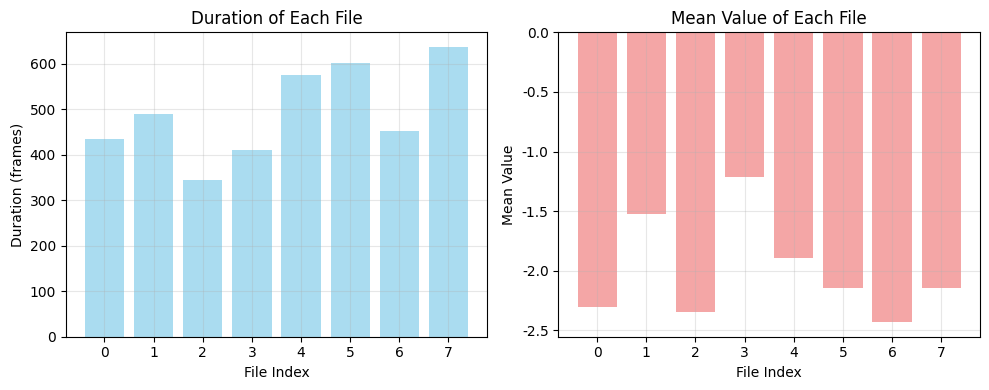

In [6]:
def analyze_first_8_files(audio_data_list):
    if len(audio_data_list) == 0:
        print("❌ 没有数据可分析")
        return
    
    print("📈 前8个文件统计分析:")
    print("="*60)
    
    # 收集所有统计数据
    durations = []                                      # 存储所有文件的时长
    min_values = []                                     # 存储所有文件的最小值
    max_values = []                                     # 存储所有文件的最大值
    mean_values = []                                    # 存储所有文件的平均值
    
    # 遍历每个文件收集统计信息
    for i, (mel_features, file_info) in enumerate(audio_data_list):
        durations.append(file_info['duration_frames'])   # 添加时长
        min_values.append(file_info['min_value'])        # 添加最小值
        max_values.append(file_info['max_value'])        # 添加最大值
        mean_values.append(file_info['mean_value'])      # 添加平均值
    
    # 转换为numpy数组便于计算
    durations = np.array(durations)
    min_values = np.array(min_values)
    max_values = np.array(max_values)
    mean_values = np.array(mean_values)
    
    # 打印统计结果
    print(f"📊 文件数量: {len(audio_data_list)}")
    print(f"⏱️  时长统计 (帧):")
    print(f"   平均: {durations.mean():.1f}, 最短: {durations.min()}, 最长: {durations.max()}")
    print(f"   标准差: {durations.std():.1f}")
    
    print(f"📏 数值范围统计:")
    print(f"   最小值范围: [{min_values.min():.3f}, {min_values.max():.3f}]")
    print(f"   最大值范围: [{max_values.min():.3f}, {max_values.max():.3f}]")
    print(f"   平均值范围: [{mean_values.min():.3f}, {mean_values.max():.3f}]")
    
    # 简单的时长分布可视化
    plt.figure(figsize=(10, 4))
    
    # 左侧：时长分布
    plt.subplot(1, 2, 1)
    plt.bar(range(len(durations)), durations, color='skyblue', alpha=0.7)  # 条形图显示每个文件的时长
    plt.xlabel('File Index')                            # x轴标签
    plt.ylabel('Duration (frames)')                     # y轴标签
    plt.title('Duration of Each File')                  # 子图标题
    plt.xticks(range(len(durations)))                   # 设置x轴刻度
    plt.grid(True, alpha=0.3)                          # 添加网格
    
    # 右侧：平均值分布
    plt.subplot(1, 2, 2)
    plt.bar(range(len(mean_values)), mean_values, color='lightcoral', alpha=0.7)  # 条形图显示每个文件的平均值
    plt.xlabel('File Index')                            # x轴标签
    plt.ylabel('Mean Value')                            # y轴标签
    plt.title('Mean Value of Each File')                # 子图标题
    plt.xticks(range(len(mean_values)))                 # 设置x轴刻度
    plt.grid(True, alpha=0.3)                          # 添加网格
    
    plt.tight_layout()                                  # 调整布局
    plt.show()                                          # 显示图片

# 执行统计分析
if len(first_8_files) > 0:
    analyze_first_8_files(first_8_files)
else:
    print("❌ 没有数据可分析")